# This tutorial shows how to run Cytocraft on subcell-resolution ST data

## Preprocessing

### Load packages

In [118]:
import os
import pandas as pd
import cytocraft.craft as cc
gem_path = './demo/merfish_ileum/transcripts.gem.csv'
obs_path = './demo/merfish_ileum/cell_feature.csv'

### Read gene expression matrix file and corresponding cell meta file of ST

In [119]:
gem = cc.read_gem_as_csv(gem_path, sep=',')

In [45]:
gem

,CellID,x,y,geneID,MIDCount
0,1,1705,1271,Maoa,1.0
1,2,1725,1922,Maoa,1.0
2,2,1753,1863,Maoa,1.0
3,2,1760,1865,Maoa,1.0
4,3,1904,794,Maoa,1.0
...,...,...,...,...,...
819660,1365,5704,38,Hrh1,1.0
819661,1365,5685,43,Htr4,1.0
819662,1365,5631,61,Taar6,1.0
819663,1365,5720,62,Taar7a,1.0


In [40]:
obs = pd.read_csv(obs_path, sep=',')
# remove the removed cells
obs=obs[obs['leiden_final']!='Removed']

In [41]:
obs

,cell,x,y,n_transcripts,density,elongation,area,avg_confidence,leiden_final
0,1,2072.205128,16.128205,39,0.021590,5.082,1806.0,0.8647,Endothelial
1,2,2150.690909,41.678788,165,0.020160,1.565,8186.0,0.9528,Smooth Muscle
2,3,2079.841727,76.071942,139,0.022790,1.820,6100.0,0.9762,Smooth Muscle
3,4,2092.325000,165.762500,80,0.018280,1.546,4376.0,0.9076,Smooth Muscle
4,5,2242.400000,18.280000,75,0.024790,3.475,3025.0,0.8952,Smooth Muscle
...,...,...,...,...,...,...,...,...,...
5766,5767,4780.526316,3869.684211,19,0.026550,3.860,715.5,0.9513,Enterocyte (Top Villus)
5770,5771,3787.700000,583.300000,10,0.009294,2.028,1076.0,0.9421,Enterocyte (Mid Villus)
5779,5780,5222.615385,8772.846154,13,0.014170,16.760,917.5,0.9312,Stem + TA
5781,5782,3443.093750,6169.906250,32,0.010670,6.223,2998.0,0.9591,Enterocyte (Mid Villus)


### Splitting gem files based on the cell type of the meta file

In [46]:
print(obs.columns)
# keys are from obs column indeces
ct_key = 'leiden_final'
ci_key = 'cell'
split_paths = craft.split_gem(gem_path, obs, ct_key, ci_key, gsep=',')

Index(['cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area',
       'avg_confidence', 'leiden_final'],
      dtype='object')
split gem path of Endothelial: ./demo/merfish_ileum/transcripts.gem.csv.leiden_final.Endothelial.tsv
split gem path of Smooth Muscle: ./demo/merfish_ileum/transcripts.gem.csv.leiden_final.Smooth_Muscle.tsv
split gem path of Telocyte: ./demo/merfish_ileum/transcripts.gem.csv.leiden_final.Telocyte.tsv
split gem path of ICC: ./demo/merfish_ileum/transcripts.gem.csv.leiden_final.ICC.tsv
split gem path of Stromal: ./demo/merfish_ileum/transcripts.gem.csv.leiden_final.Stromal.tsv
split gem path of Macrophage + DC: ./demo/merfish_ileum/transcripts.gem.csv.leiden_final.Macrophage__DC.tsv
split gem path of Paneth: ./demo/merfish_ileum/transcripts.gem.csv.leiden_final.Paneth.tsv
split gem path of B (Plasma): ./demo/merfish_ileum/transcripts.gem.csv.leiden_final.B_Plasma.tsv
split gem path of T (CD4+): ./demo/merfish_ileum/transcripts.gem.csv.leiden_final.T_CD

## Run Cytocraft

In [52]:
adatas={}
for ct, ct_gem_path in split_paths.items():
    print('run Cytocraft for cell type:', ct)
    gem = cc.read_gem_as_csv(ct_gem_path, sep='\t')
    adata = cc.read_gem_as_adata(ct_gem_path,sep='\t')
    # perform Cytocraft and save results to adata
    adatas[ct] = craft.craft(
            gem=gem,
            adata=adata,
            species='Mice',
            seed=999,
            thresh_rmsd=0.1,
            samplename='ileum_test'
        )

run Cytocraft for cell type: Endothelial
Adding adata in adata.obs['orig.ident'].
Adding data.position as adata.obsm['spatial'] .
Adding data.position as adata.obs['x'] and adata.obs['y'] .
Finished conversion to anndata.
Speceis: Mice
Sample Name: ileum_test
Seed: 999
Cell Number: 203
Gene Number: 220
Cutoff for gene filter is: 0.9
Anchor Gene Number is: 10
Task ID: 2C5U

RMSD between New Configuration and Old Configuration for loop 1 is: 1.4688249334497945
RMSD between New Configuration and Old Configuration for loop 2 is: 0.8285719322714017
RMSD between New Configuration and Old Configuration for loop 3 is: 0.5803325555593686
RMSD between New Configuration and Old Configuration for loop 4 is: 0.4388473847362445
RMSD between New Configuration and Old Configuration for loop 5 is: 0.3723291151327591
RMSD between New Configuration and Old Configuration for loop 6 is: 0.33660407991696806
RMSD between New Configuration and Old Configuration for loop 7 is: 0.294956875392053
RMSD between Ne

## Analysis

### Data view

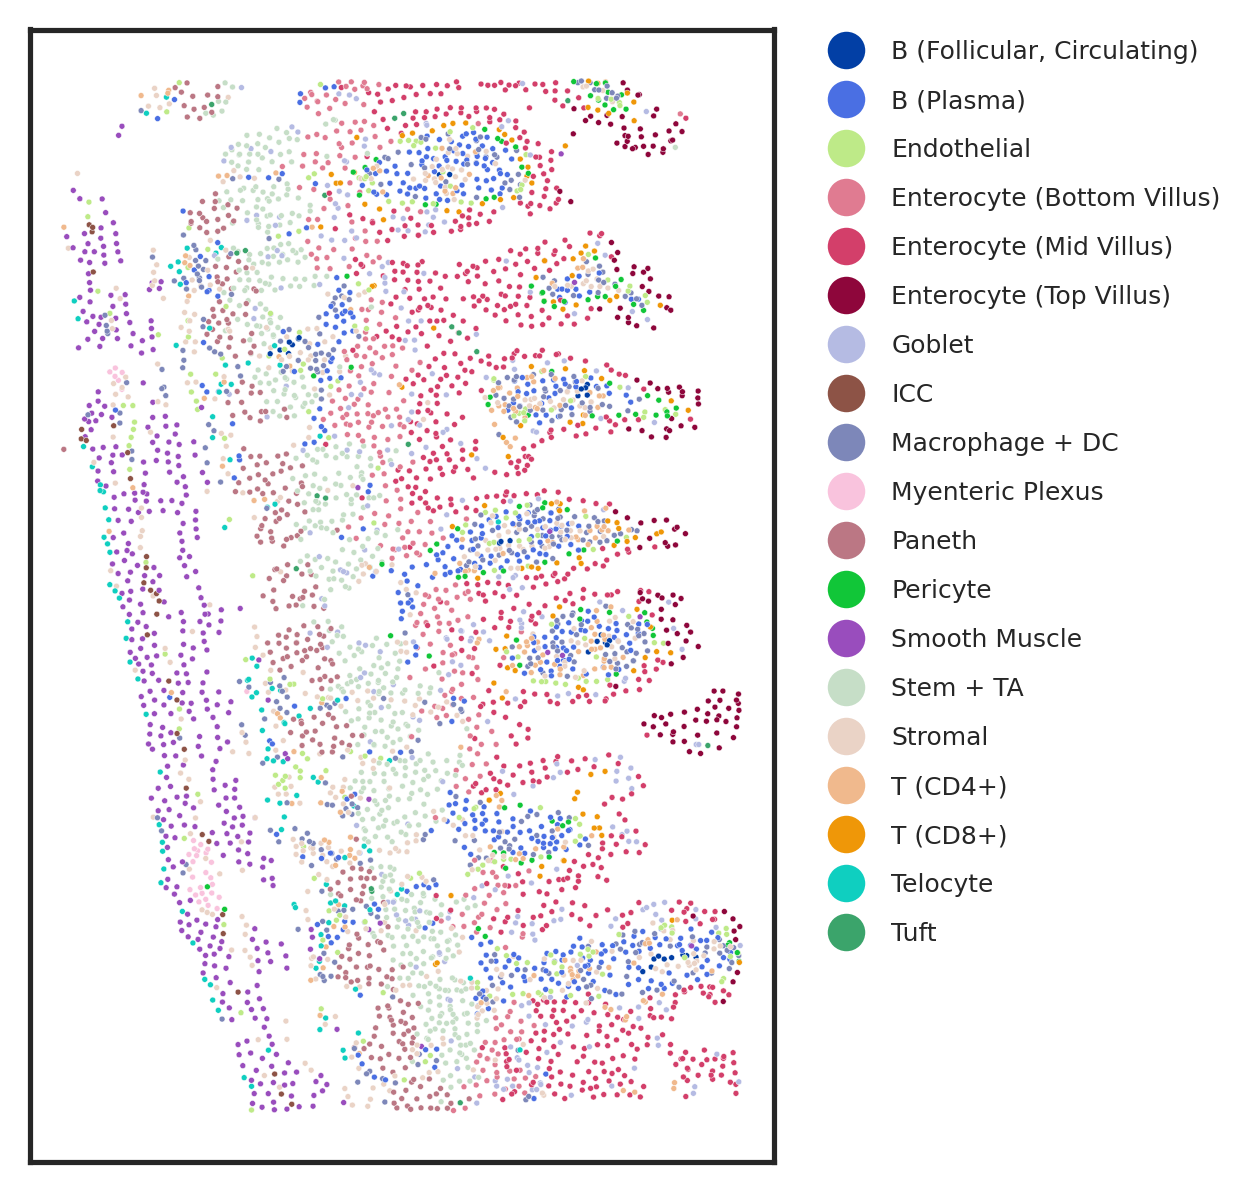

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

color_map={'B (Follicular, Circulating)': '#023fa5',
 'B (Plasma)': '#4a6fe3',
 'Endothelial': '#BEEA88',
 'Enterocyte (Bottom Villus)': '#e07b91',
 'Enterocyte (Mid Villus)': '#d33f6a',
 'Enterocyte (Top Villus)': '#8e063b',
 'Goblet': '#b5bbe3',
 'ICC': '#8D5346',
 'Macrophage + DC': '#7d87b9',
 'Myenteric Plexus': '#F9C3DD',
 'Paneth': '#bb7784',
 'Pericyte': '#11c638',
 'Smooth Muscle': '#994DBD',
 'Stem + TA': '#c6dec7',
 'Stromal': '#ead3c6',
 'T (CD4+)': '#f0b98d',
 'T (CD8+)': '#ef9708',
 'Telocyte': '#0fcfc0',
 'Tuft': '#3BA46B'}

sns.set(rc={"figure.dpi":300,'figure.figsize':(3.2, 5)}, font_scale=1)
sns.set_theme(style='white', palette='pastel')
g=sns.scatterplot(data=obs, x="x", y="y", hue="leiden_final", palette=color_map, s=2)
g.set_xlabel
g.set_xlabel("")
g.set_ylabel("")
g.set_yticks([])
g.set_xticks([])

from matplotlib.patches import Patch
lut = color_map
handles=[Line2D([0], [0], marker='o', color='w', markerfacecolor=lut[name], markersize=10) for name in sorted(lut)]
plt.legend(handles, sorted(lut), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, frameon=False, fontsize=6, labelspacing=1)

### Configuration view (components)

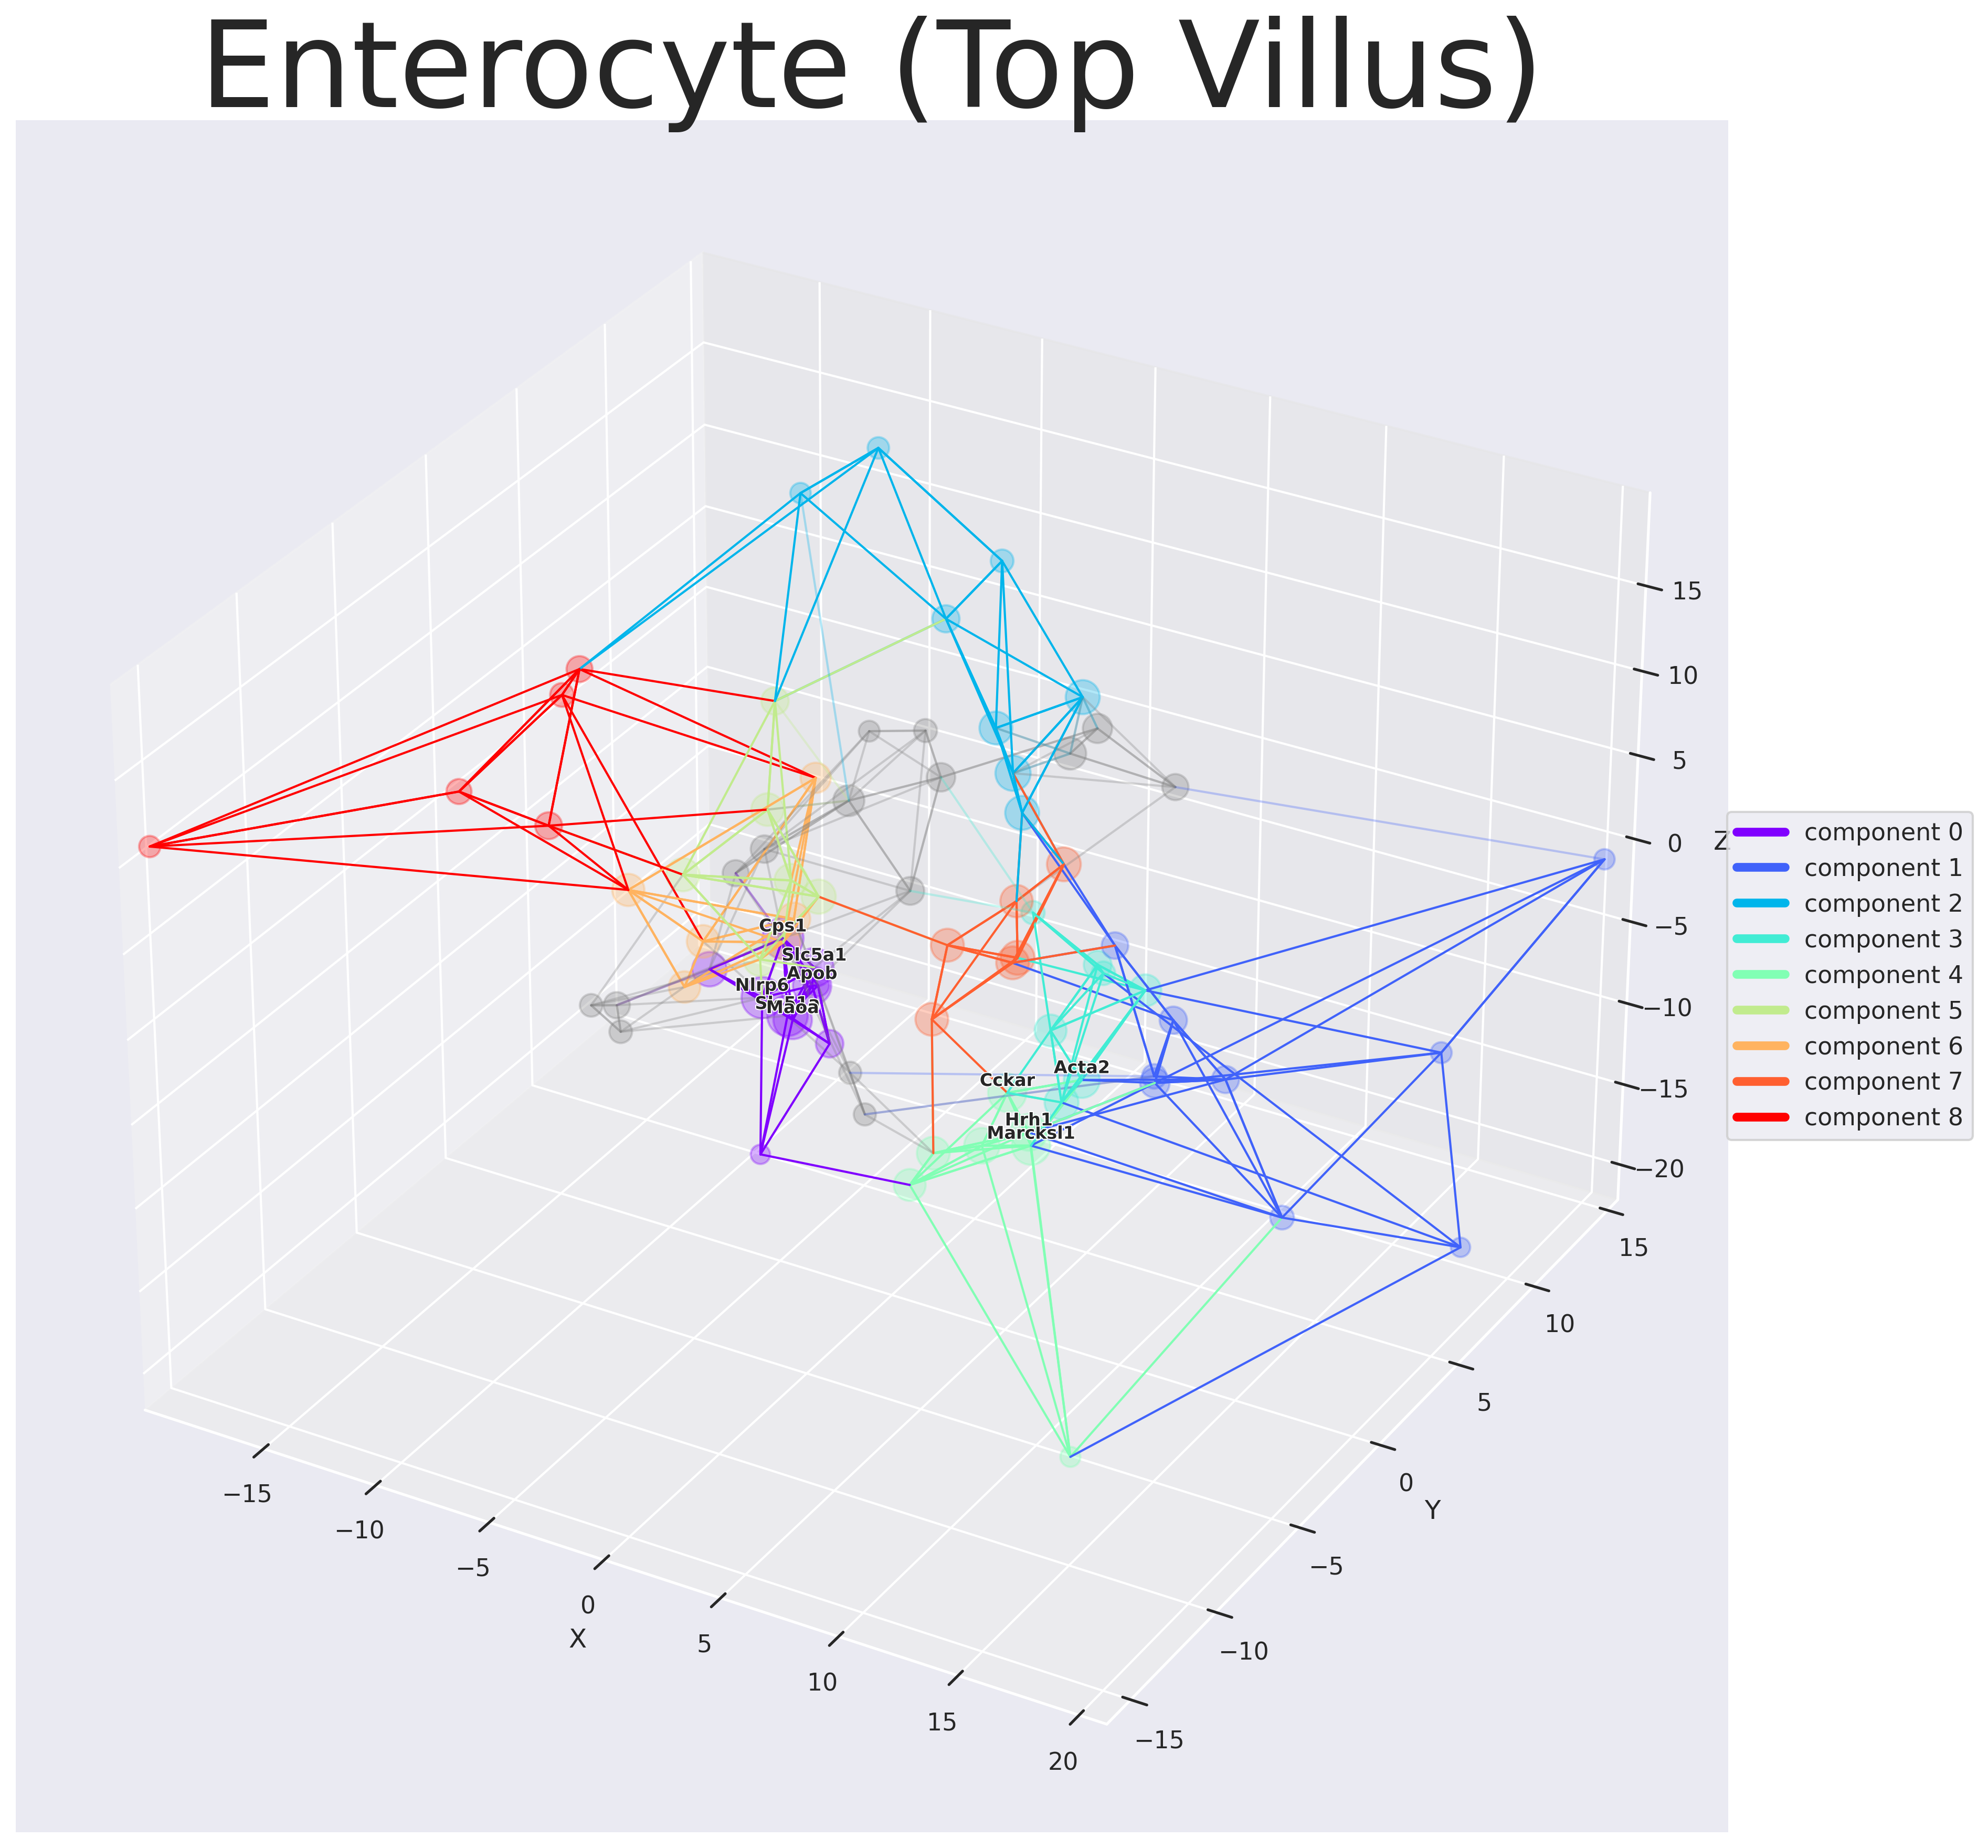

<Figure size 2400x2400 with 0 Axes>

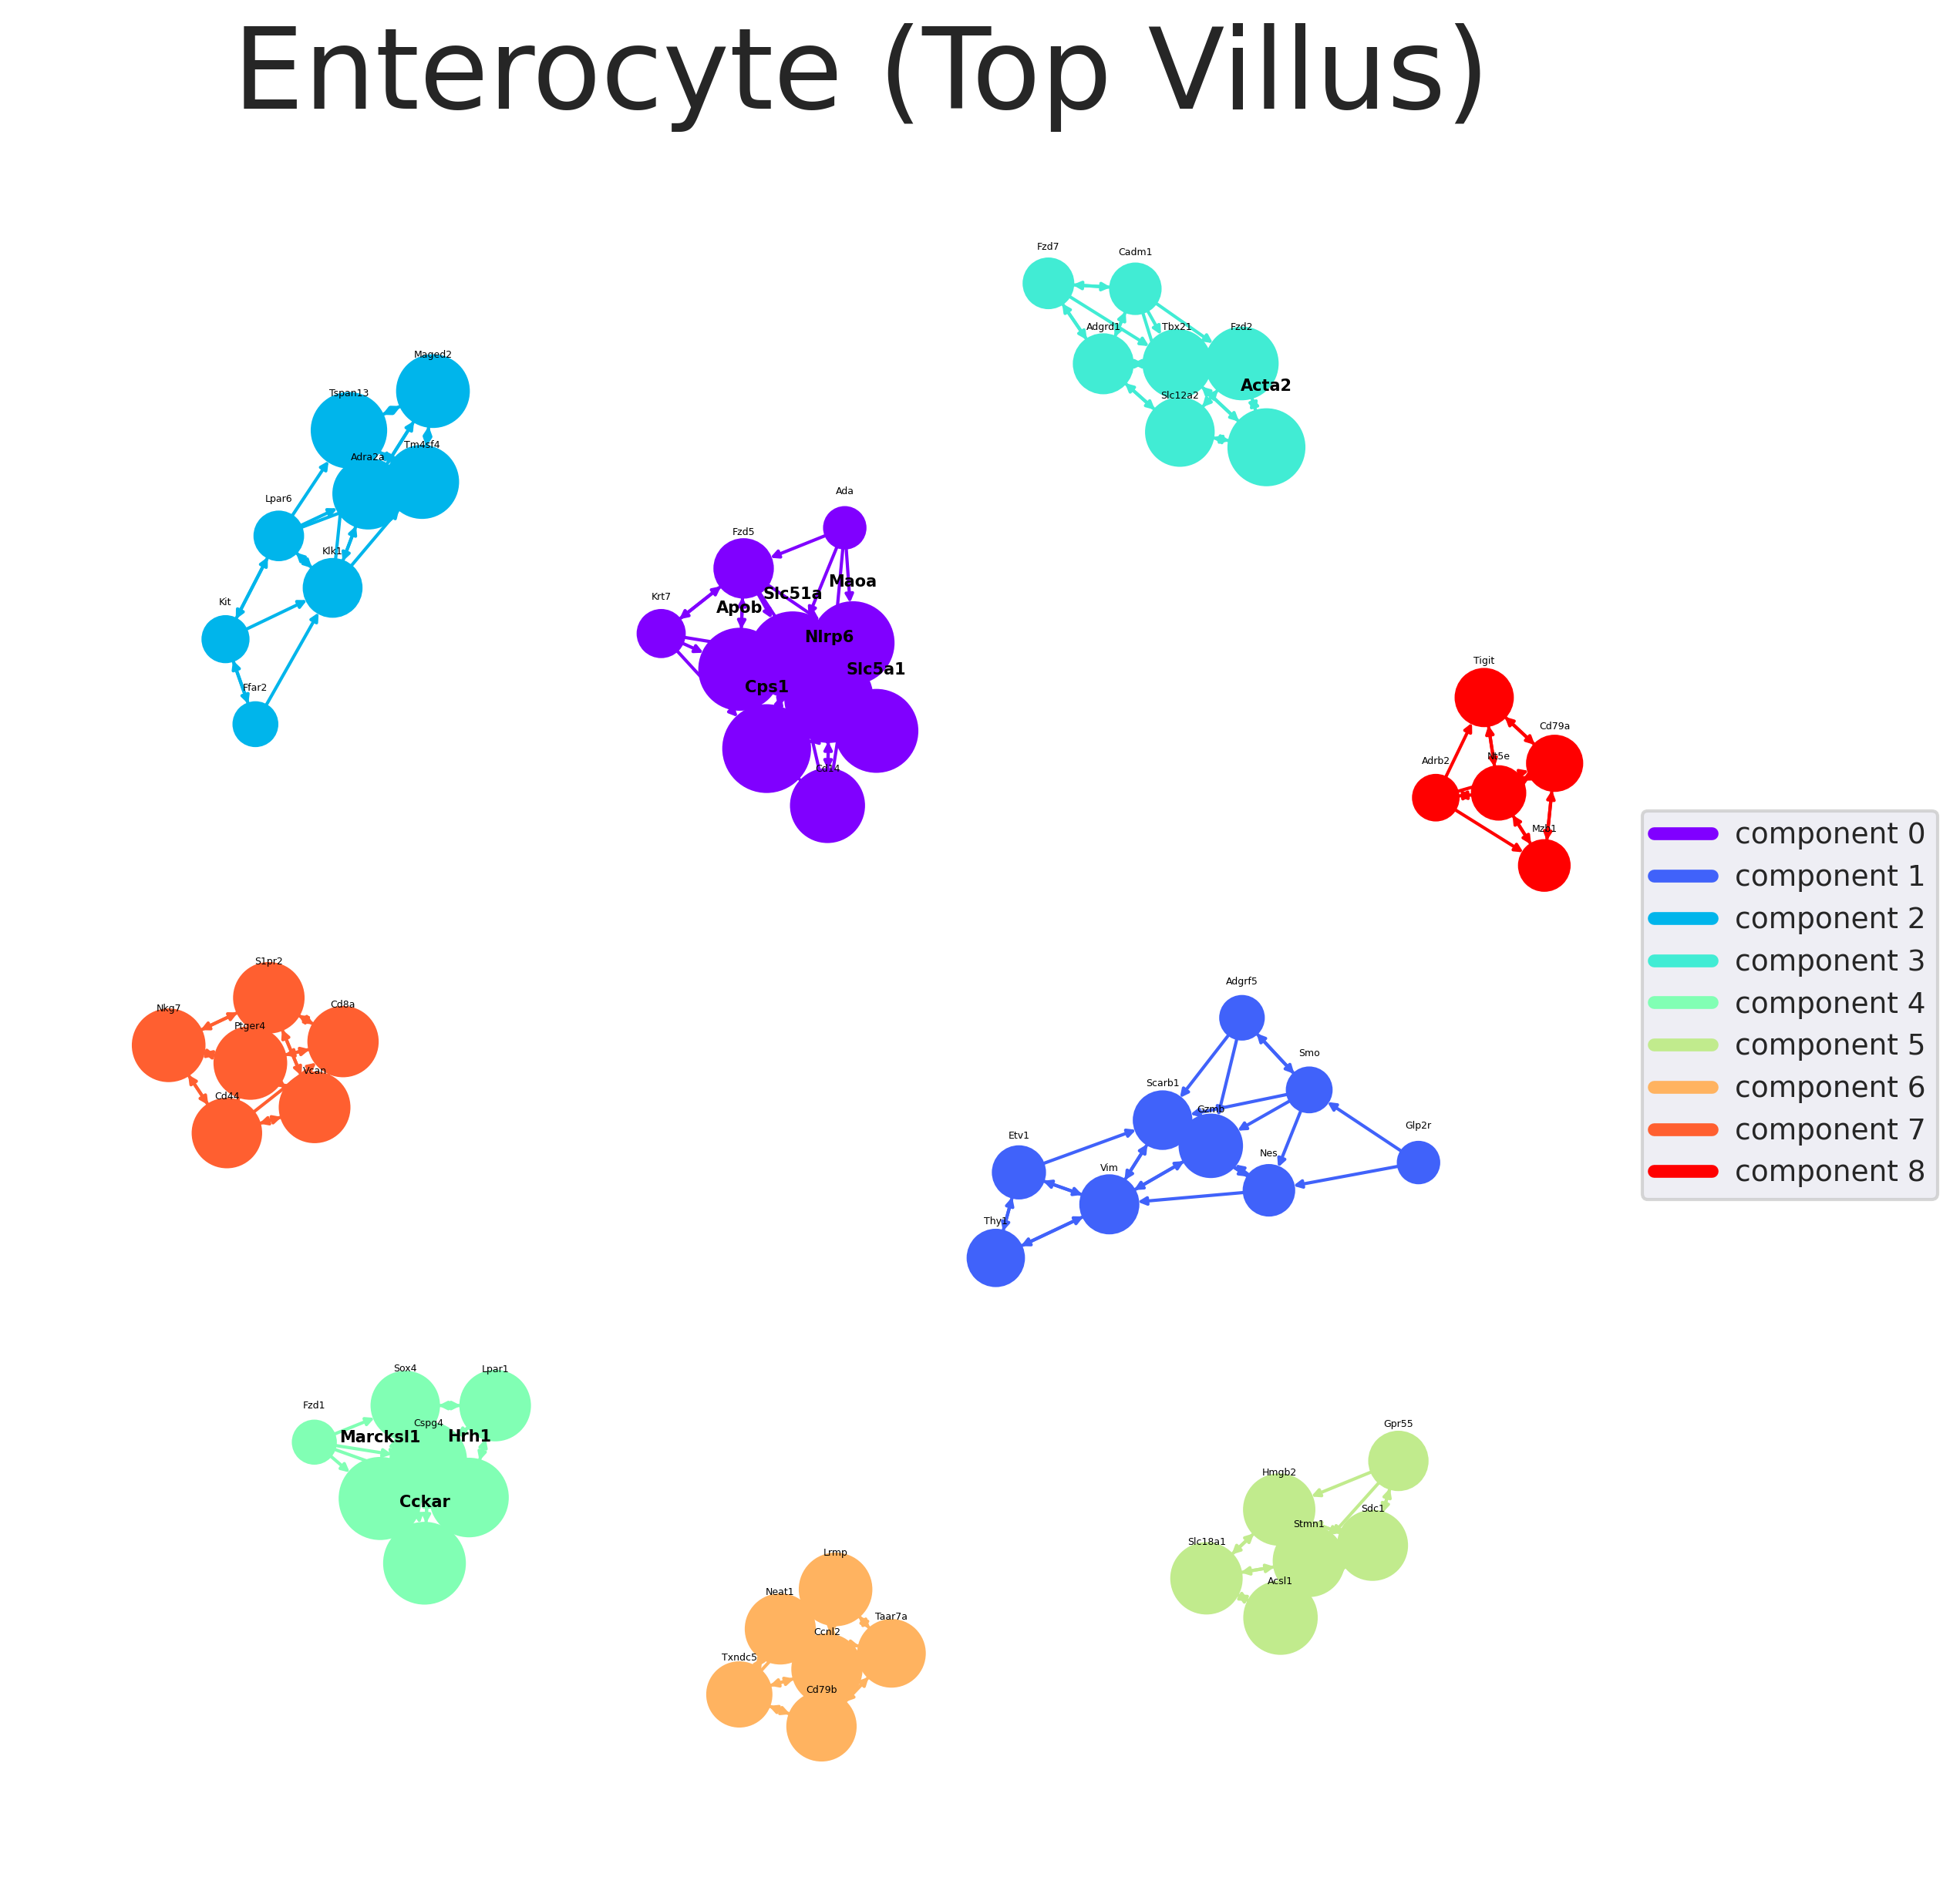

<Figure size 2400x2400 with 0 Axes>

In [150]:
import networkx as nx
node_coords = adatas['Enterocyte (Top Villus)'].uns['F']

G = nx.DiGraph()
for node in node_coords.T:
    G.add_node(node, pos=node_coords.loc[node])

G_KNN = connect_edge_knn(G, k=5)
draw_5NN(G_KNN, title='Enterocyte (Top Villus)', save_path='./demo/merfish_ileum/results/Enterocyte(TopVillus)/')

### RMSD distance matrix

In [74]:
from cytocraft.craft import kabsch_numpy, mirror, normalizeF
def RMSD_distance_matrix(
    adatas, order=None, ngene=100, compare_method="pair", norm_method=None
):
    """
    Calculate the RMSD distance matrix between configurations of different cell types
    Parameters
    ----------
    Confs : dict
        The dictionary of the configurations of different cell types
    GeneLists : dict
        The dictionary of the gene lists of different cell types
    order : list, optional
        The order of the cell types, by default None
    ngene : int, optional
        The number of genes to be compared, by default 100
    compare_method : str, optional
        The method to compare the gene lists, by default "pair"
    norm_method : str, optional
        The method to normalize the configurations, by default None
    Returns
    -------
    np.ndarray
        The RMSD distance matrix
    """
    import numpy as np
    
    if order == None:
        keys = list(adatas.keys())
    else:
        keys = order

    GeneLists = {}
    for ct, adata in adatas.items():
        if "F" not in adata.uns.keys():
            print(f"Please run Cytocraft for {ct} first")
            return
        GeneLists[ct] = adata.uns['F'].index
    
    # calculate the distance matrix
    N = len(keys)
    DM = np.zeros((N, N))
    if compare_method == "complete":
        from functools import reduce

        intersected_values = reduce(np.intersect1d, GeneLists.values())
        intersected_values = intersected_values[:ngene]
        if len(intersected_values) < ngene:
            print(
                f"Warning: {len(intersected_values)} common genes between samples are less than {ngene}"
            )
    from tqdm import tqdm

    for n, key_n in enumerate(tqdm(keys)):
        for m, key_m in enumerate(keys[: n + 1]):
            if compare_method == "pair":
                intersected_values = np.intersect1d(GeneLists[key_n], GeneLists[key_m])
                intersected_values = intersected_values[:ngene]
                if len(intersected_values) < ngene:
                    print(
                        f"Warning: {len(intersected_values)} common genes between {key_n} and {key_m} are less than {ngene}"
                    )
            boolean_arrays_n = np.in1d(GeneLists[key_n], intersected_values)
            boolean_arrays_m = np.in1d(GeneLists[key_m], intersected_values)
            Conf_n = adatas[key_n].uns['F'][boolean_arrays_n]
            Conf_m = adatas[key_m].uns['F'][boolean_arrays_m]
            if norm_method:
                Conf_n = normalizeF(Conf_n, method=norm_method)
                Conf_m = normalizeF(Conf_m, method=norm_method)
            rmsd1 = kabsch_numpy(Conf_n, Conf_m)[2]
            rmsd2 = kabsch_numpy(mirror(Conf_n), Conf_m)[2]
            DM[n, m] = DM[m, n] = min(rmsd1, rmsd2)
    return DM

In [110]:
D_ileum = RMSD_distance_matrix(adatas, ngene=19, compare_method='pair', norm_method=None)

100%|██████████| 19/19 [00:00<00:00, 129.58it/s]


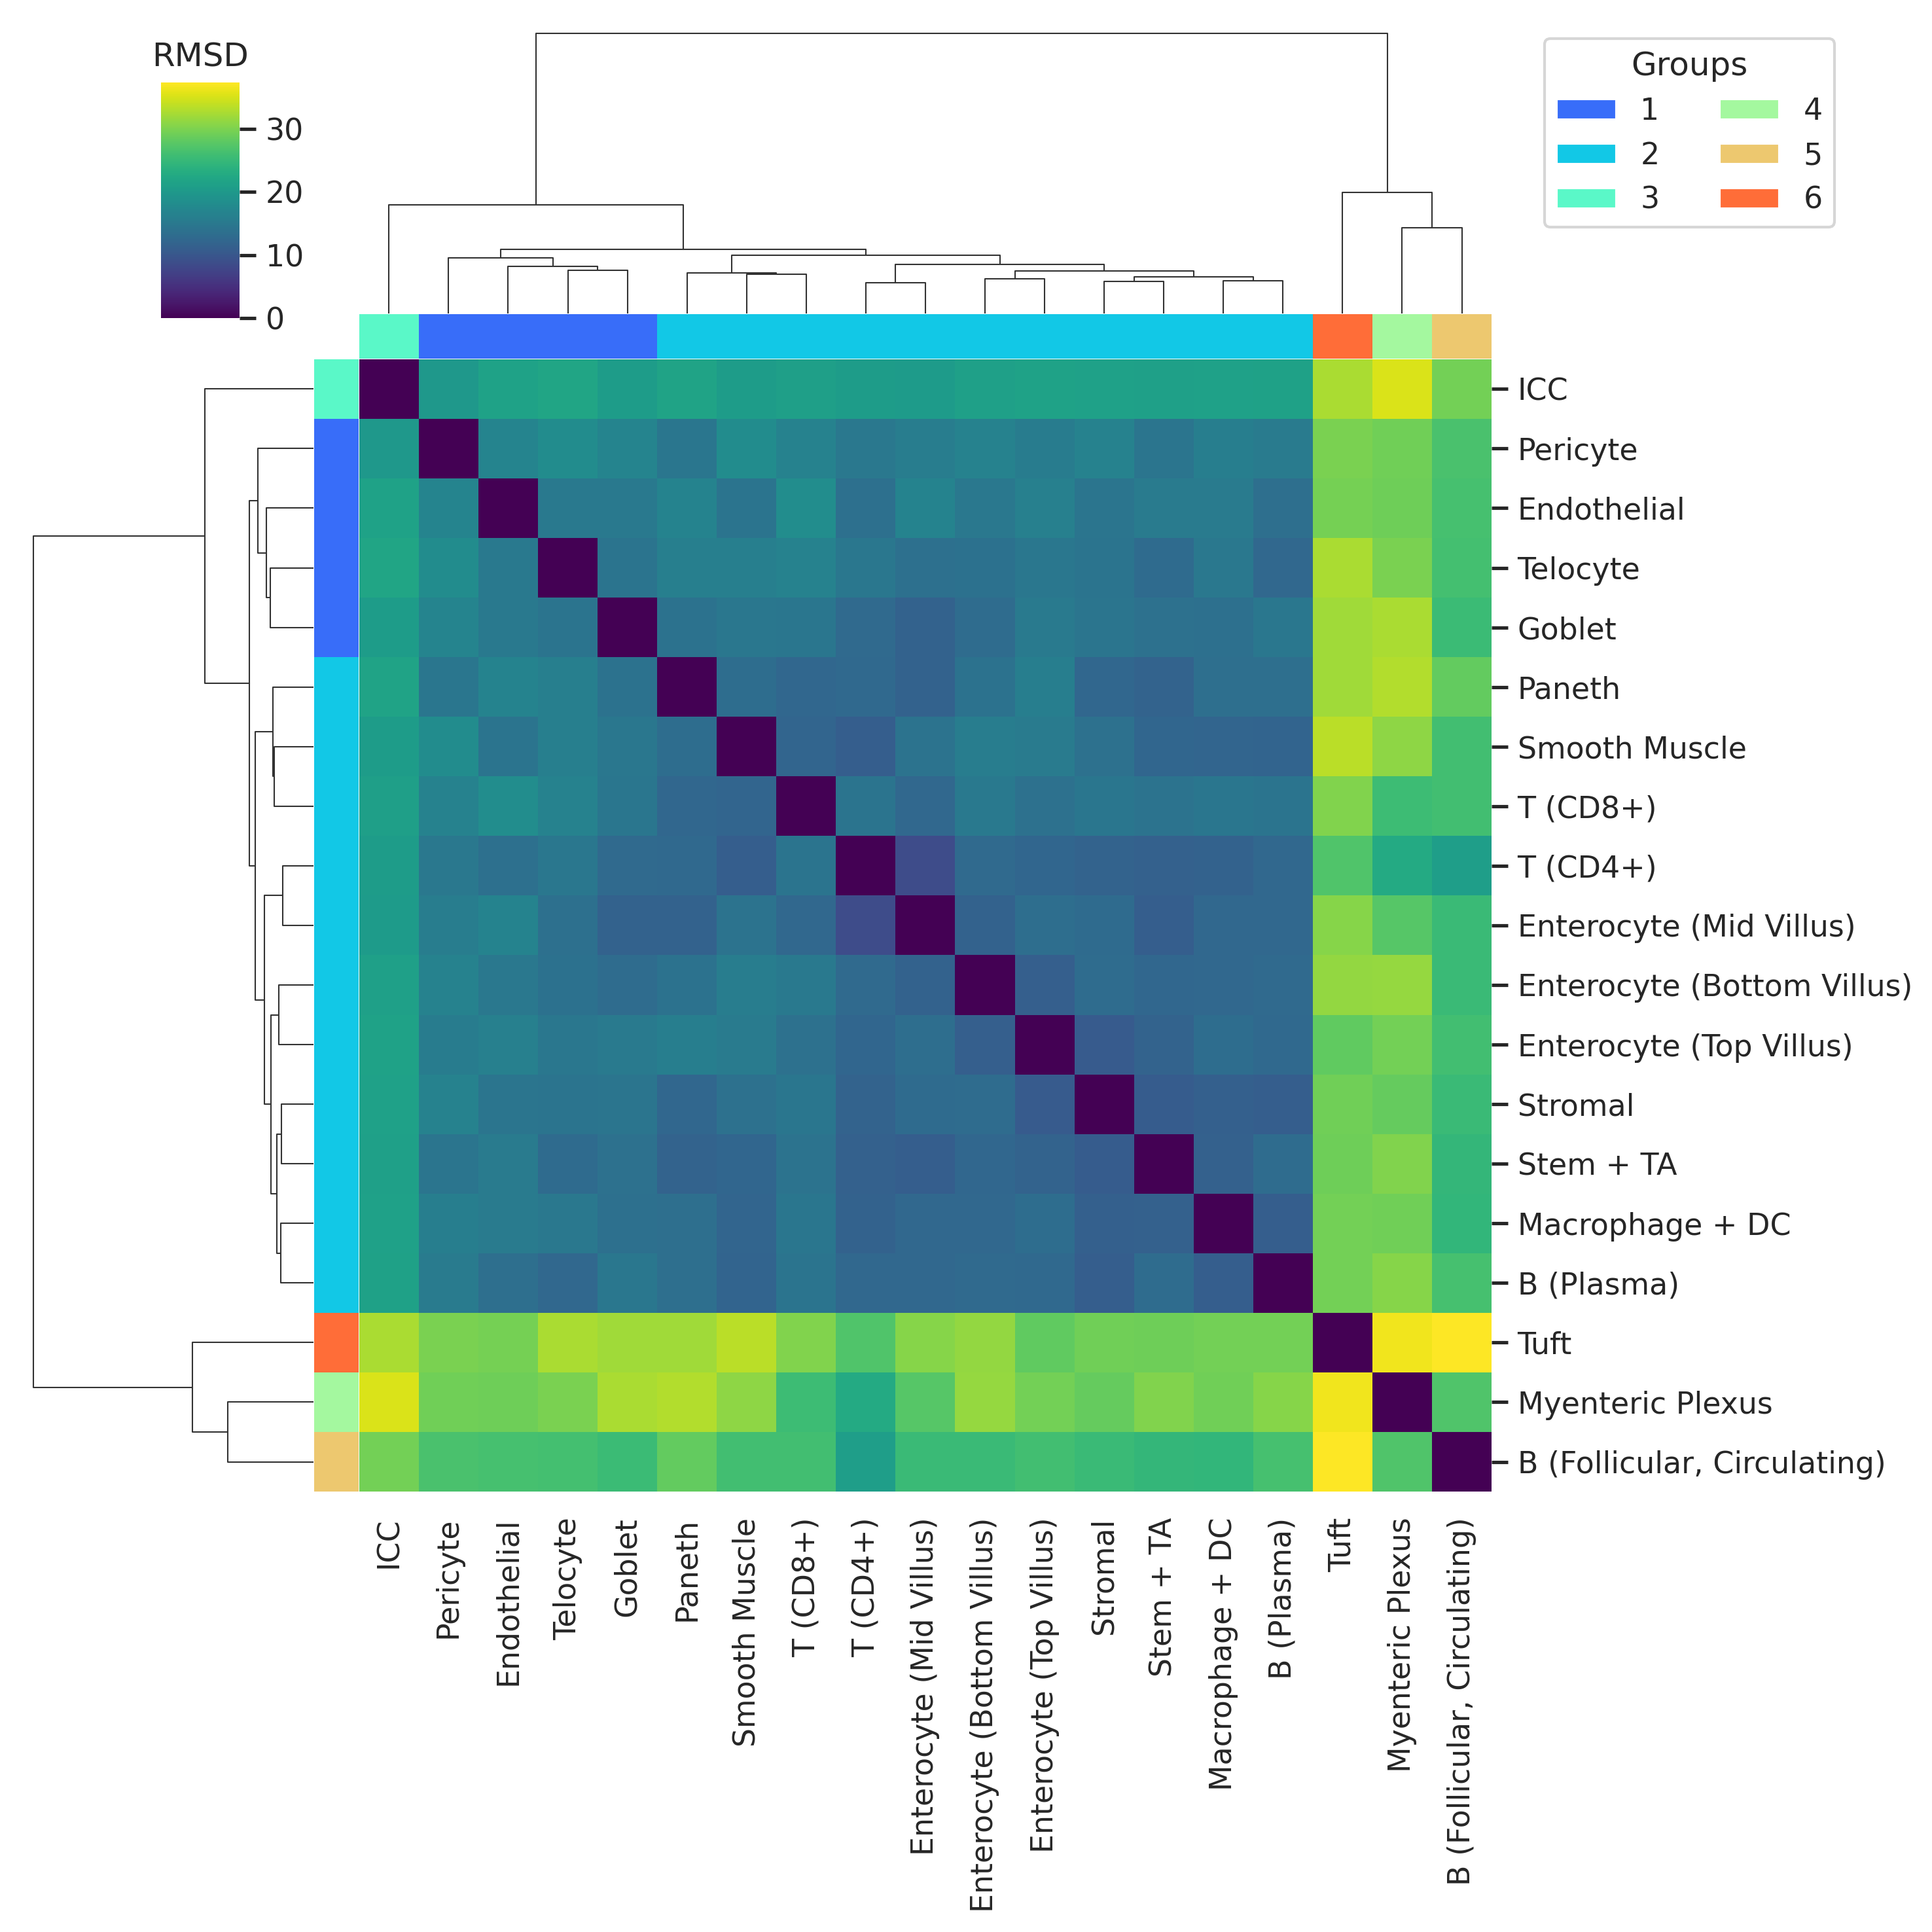

In [117]:
from cytocraft.plot import plot_RMSD_heatmap
plot_RMSD_heatmap(D_ileum, labels=list(adatas.keys()), cmap='viridis', method='ward', cthresh = 30, dpi=300, 
                cbbox=(.09, .83, .04, .12), lgbox=(0.94, 0.97, .01, .01), ticks=[0,10,20,30,40])